# Box office Prediction


## Project definition:

To try and build a model to predict for a given movie its overall worldwide Box Office revenue.
The data set includes past movies with information about them including the cast, the director, plot keywords… And of course, for the training data points we have the classification (total Box office revenue)

## Data Exploration:

First step to start with is always to explore the data set we are given. This will include independently analyzing each of the features, finding correlations between them, dimensionality reduction and feature selection.

In [30]:
import pandas as pd
pd.set_option('max_columns', None)
import numpy as np
import ast
import matplotlib.pyplot as plt

### Features:

The features we have in the data set are:

In [31]:
train_set = pd.read_csv('data/train.csv')
test_set = pd.read_csv('data/test.csv')
train_set.columns

Index([u'id', u'belongs_to_collection', u'budget', u'genres', u'homepage',
       u'imdb_id', u'original_language', u'original_title', u'overview',
       u'popularity', u'poster_path', u'production_companies',
       u'production_countries', u'release_date', u'runtime',
       u'spoken_languages', u'status', u'tagline', u'title', u'Keywords',
       u'cast', u'crew', u'revenue'],
      dtype='object')

Some of these features have strings values, 
others are lists of dictionaries displayed as strings.
We will convert these features to python dictionaries for ease of access.

In [32]:
LIST_COLS = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def convert_text_cols_to_list(df):
    for col in LIST_COLS:
        df[col] = [{} if pd.isna(value) else ast.literal_eval(value) for value in df[col]]
    return df

train_set = convert_text_cols_to_list(train_set)
test_set = convert_text_cols_to_list(test_set)

In [33]:
train_set.head(2)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,[{u'backdrop_path': u'/noeTVcgpBiD48fDjFVic1Vz...,14000000,"[{u'id': 35, u'name': u'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{u'name': u'Paramount Pictures', u'id': 4}, {...","[{u'iso_3166_1': u'US', u'name': u'United Stat...",2/20/15,93.0,"[{u'iso_639_1': u'en', u'name': u'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{u'id': 4379, u'name': u'time travel'}, {u'id...","[{u'name': u'Rob Corddry', u'gender': 2, u'cha...","[{u'name': u'Kelly Cantley', u'gender': 0, u'd...",12314651
1,2,[{u'backdrop_path': u'/zSEtYD77pKRJlUPx34BJgUG...,40000000,"[{u'id': 35, u'name': u'Comedy'}, {u'id': 18, ...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{u'name': u'Walt Disney Pictures', u'id': 2}]","[{u'iso_3166_1': u'US', u'name': u'United Stat...",8/6/04,113.0,"[{u'iso_639_1': u'en', u'name': u'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{u'id': 2505, u'name': u'coronation'}, {u'id'...","[{u'name': u'Anne Hathaway', u'gender': 1, u'c...","[{u'name': u'Garry Marshall', u'gender': 2, u'...",95149435


Now we’ll go through each of these features and analyze their potentional contribution to the classification/their correlations with other features, and possibly construct new features using the existing ones

#### i.	Genres feature:
As we can see from the table above, movies might belong to more than one genre, the values for this feature are a list which its elements are dictionaries with a genre id and a genre name. for example the movie with the id 1 belongs to genres Comedy (genre id 35), Drama(genre id 18), Family (genre id 10751) and Romance (genre id 10749).
	


In [34]:
train_set["genres"][1]

[{'id': 35, 'name': 'Comedy'},
 {'id': 18, 'name': 'Drama'},
 {'id': 10751, 'name': 'Family'},
 {'id': 10749, 'name': 'Romance'}]

The genre id will probably not be helpful for extracting information about the movie, it is just an overhead. 
We could use the genre id *instead* of using the genre name, we prefer to use the names since it is easier to comprehend.

Since we can’t define any order for genres, a good approach for dealing with such a nominal feature is to transform it to a group of “dummy” binary features. I.e. each feature will indicate whether or not the movie belongs to the specific genre.
For example: The movie with the id 1 will have the value 1 for the newly constructed features genre_name_comedy, genre_name_drama, genre_name_family and genre_name_romance, and 0 in all the other “genre_name_” feature.

In [35]:
genre_names_with_repetions = list(x["name"] for l in train_set["genres"] for x in l)
genre_names_with_repetions

['Comedy',
 'Comedy',
 'Drama',
 'Family',
 'Romance',
 'Drama',
 'Thriller',
 'Drama',
 'Action',
 'Thriller',
 'Animation',
 'Adventure',
 'Family',
 'Horror',
 'Thriller',
 'Documentary',
 'Action',
 'Comedy',
 'Music',
 'Family',
 'Adventure',
 'Comedy',
 'Music',
 'Drama',
 'Comedy',
 'Drama',
 'Comedy',
 'Crime',
 'Action',
 'Thriller',
 'Science Fiction',
 'Mystery',
 'Action',
 'Crime',
 'Drama',
 'Horror',
 'Thriller',
 'Drama',
 'Romance',
 'Comedy',
 'Romance',
 'Action',
 'Thriller',
 'Crime',
 'Adventure',
 'Family',
 'Science Fiction',
 'Horror',
 'Thriller',
 'Thriller',
 'Horror',
 'Thriller',
 'Mystery',
 'Foreign',
 'Horror',
 'Comedy',
 'Comedy',
 'Horror',
 'Mystery',
 'Thriller',
 'Crime',
 'Drama',
 'Mystery',
 'Thriller',
 'Drama',
 'Comedy',
 'Romance',
 'Animation',
 'Action',
 'Adventure',
 'Crime',
 'Thriller',
 'Drama',
 'Comedy',
 'Mystery',
 'Drama',
 'Thriller',
 'Fantasy',
 'Action',
 'Adventure',
 'Horror',
 'Action',
 'Comedy',
 'Crime',
 'Thriller',
 

Just before we jump into constructing the new dummy features, let's have a look at the popularity of each genre.

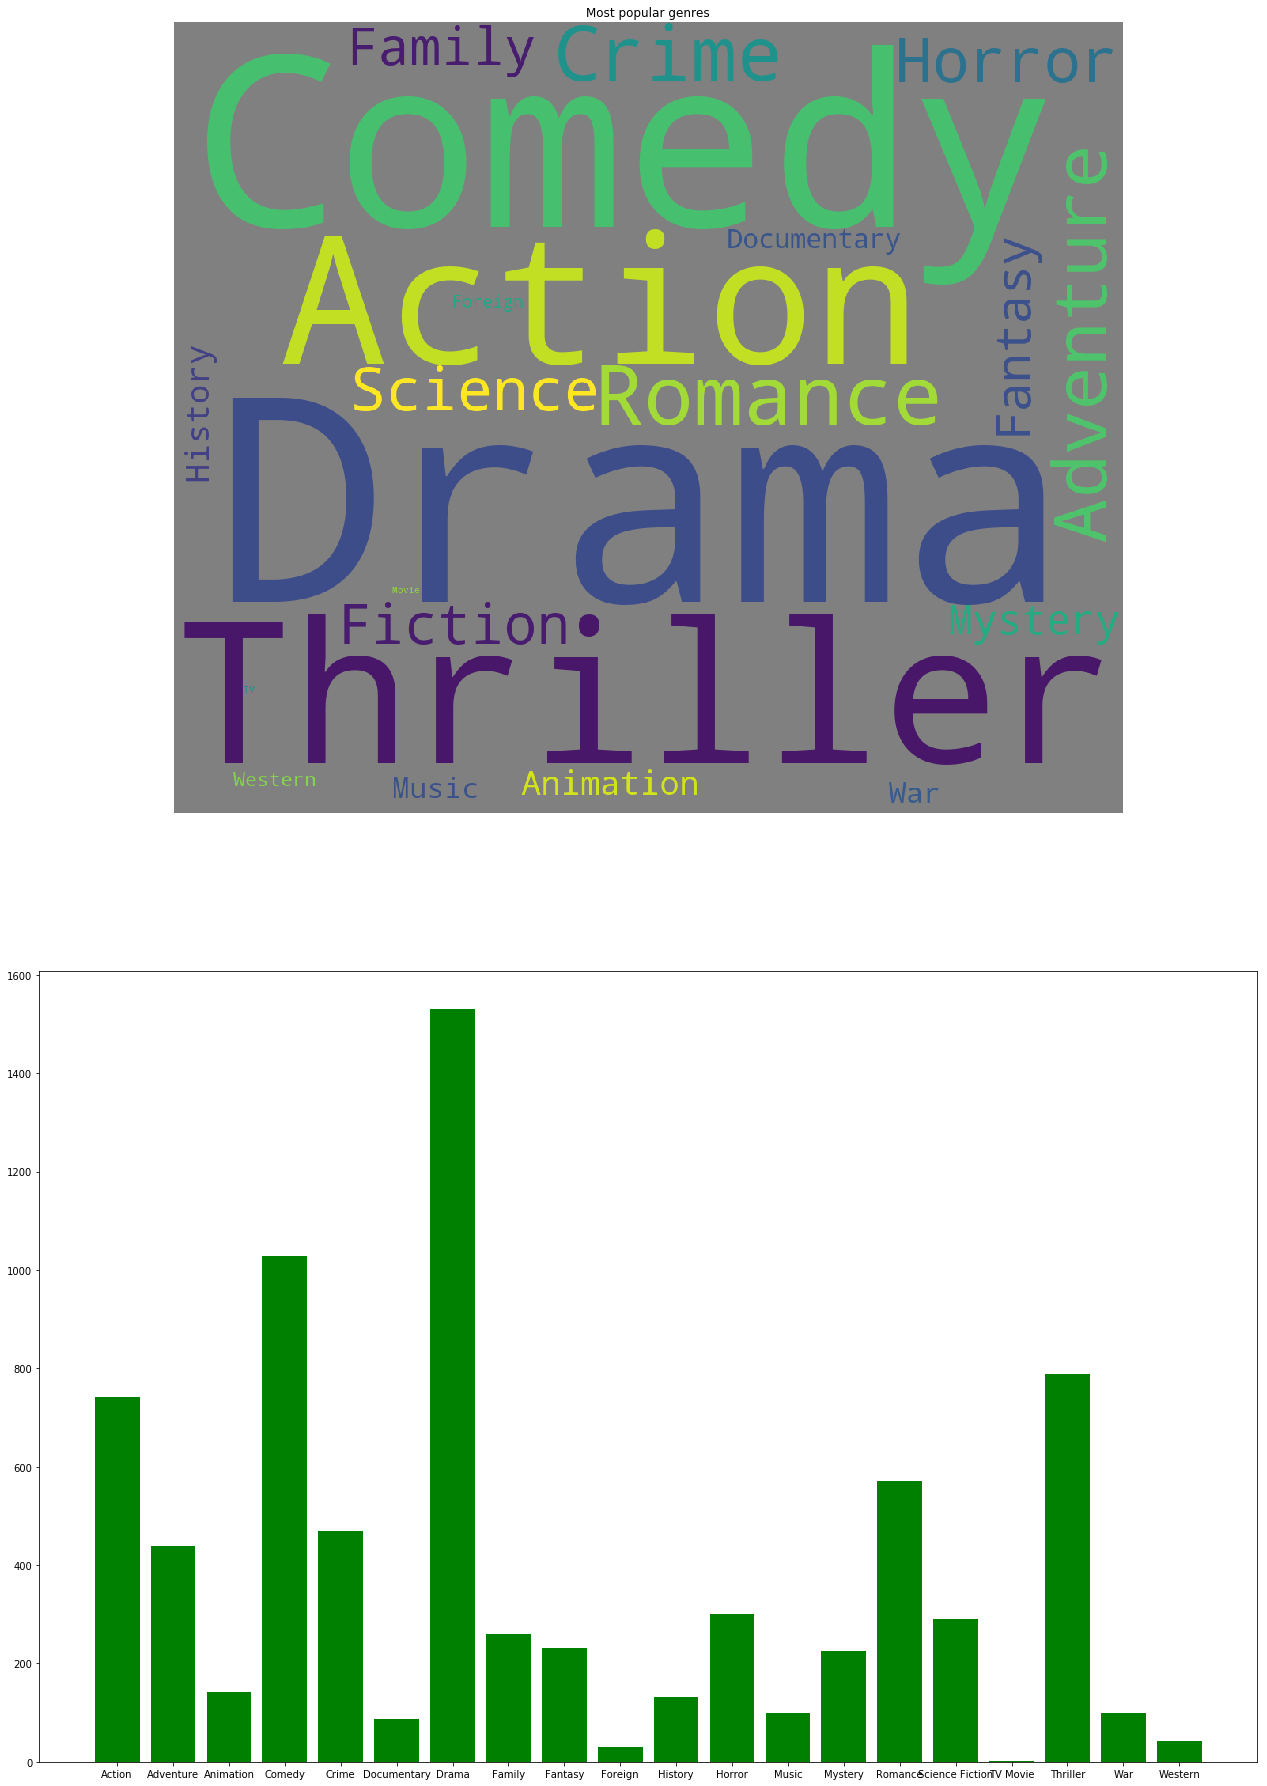

In [36]:
from wordcloud import WordCloud

plt.figure(figsize = (48, 32))
text = ' '.join([i for i in genre_names_with_repetions])

wordcloud = WordCloud(max_font_size=None, background_color='grey', collocations=False,
                      width=1200, height=1000).generate(text)
plt.subplot(2, 2, 1)
plt.imshow(wordcloud)
plt.title('Most popular genres')
plt.axis("off")

genre_names_popularity = {}
for genre in genre_names_with_repetions:
    if genre in genre_names_popularity.keys():
        continue
    genre_names_popularity[genre] = genre_names_with_repetions.count(genre)

plt.subplot(2, 2, 3)   
plt.bar(genre_names_popularity.keys(), genre_names_popularity.values(), color='g')

plt.show()

We can see that genres such like "TV Movie", "Foreign", "Western" and "Documentary" have very few appearences in comparison to other genres. We think it is safe to identify those genres as "outliers", in a sense that there is not enough data in the training set to rely on, when trying to find a difference between a movie that does belong to the "TV Movie" genre, for example, and another that doesn't.
In fact, there is only one movie that belongs to this genre, and this might be an enough of a reason for our model to determine the revenue of any movie that belongs to this genre, although it can not learn much about movies from this genre based only a single data point.

So in order to remain on the safe side and not to over-fit our model, we will create the new dummy features based only on genres that have more than 100 appearences. Other genres won't be taken into consideration for creating our model.

In [37]:
MOST_POPULAR_GENRES = [genre for genre in genre_names_popularity.keys() if genre_names_popularity[genre]>=100]
def convert_genre_feature_to_dummy_features(df):
    for genre_name in most_popular_genres:
        df["genre_name_"+genre_name] = [1 if genre_name in str(l) else 0
                                           for l in df["genres"]]
        
convert_genre_feature_to_dummy_features(train_set)
convert_genre_feature_to_dummy_features(test_set)
train_set.head(2)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,genre_name_Mystery,genre_name_Romance,genre_name_History,genre_name_Family,genre_name_Fantasy,genre_name_Horror,genre_name_Crime,genre_name_Drama,genre_name_Science Fiction,genre_name_Animation,genre_name_Music,genre_name_Adventure,genre_name_Action,genre_name_Comedy,genre_name_War,genre_name_Thriller
0,1,[{u'backdrop_path': u'/noeTVcgpBiD48fDjFVic1Vz...,14000000,"[{u'id': 35, u'name': u'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{u'name': u'Paramount Pictures', u'id': 4}, {...","[{u'iso_3166_1': u'US', u'name': u'United Stat...",2/20/15,93.0,"[{u'iso_639_1': u'en', u'name': u'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{u'id': 4379, u'name': u'time travel'}, {u'id...","[{u'name': u'Rob Corddry', u'gender': 2, u'cha...","[{u'name': u'Kelly Cantley', u'gender': 0, u'd...",12314651,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2,[{u'backdrop_path': u'/zSEtYD77pKRJlUPx34BJgUG...,40000000,"[{u'id': 35, u'name': u'Comedy'}, {u'id': 18, ...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{u'name': u'Walt Disney Pictures', u'id': 2}]","[{u'iso_3166_1': u'US', u'name': u'United Stat...",8/6/04,113.0,"[{u'iso_639_1': u'en', u'name': u'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{u'id': 2505, u'name': u'coronation'}, {u'id'...","[{u'name': u'Anne Hathaway', u'gender': 1, u'c...","[{u'name': u'Garry Marshall', u'gender': 2, u'...",95149435,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0


We can see for example, the first two movies have the correct vectors to descripe their genres.


Another interesting aspect to view the "genre" feature from is the number of genres for each movie.
To demonstrate that let's add this feature to our data and plot the relation between the number of generes and the total revenue.

Text(0.5,1,u'# of genres vs revenue')

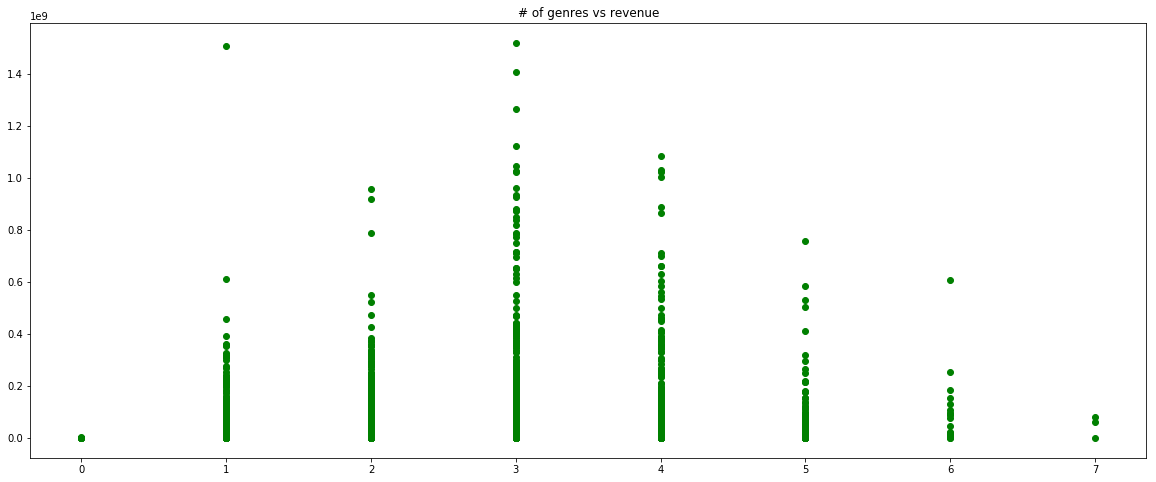

In [38]:
train_set["number_of_genres"] = [len(l) for l in train_set["genres"]]

plt.figure(figsize=(20, 8))
plt.scatter(train_set['number_of_genres'], train_set['revenue'], color="g")
plt.title('# of genres vs revenue')

It appears there is some kind of a second order relation between this new feature and the revenue. No reason to remove it. We will also construct this feature for the test set.

In [39]:
test_set["number_of_genres"] = [len(l) for l in test_set["genres"]]

Finally, we can remove the the "genres" column.

In [40]:
train_set.drop(['genres'], axis=1, inplace=True)
test_set.drop(['genres'], axis=1, inplace=True)
train_set.head(2)

,id,belongs_to_collection,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,genre_name_Mystery,genre_name_Romance,genre_name_History,genre_name_Family,genre_name_Fantasy,genre_name_Horror,genre_name_Crime,genre_name_Drama,genre_name_Science Fiction,genre_name_Animation,genre_name_Music,genre_name_Adventure,genre_name_Action,genre_name_Comedy,genre_name_War,genre_name_Thriller,number_of_genres
0,1,[{u'backdrop_path': u'/noeTVcgpBiD48fDjFVic1Vz...,14000000,NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{u'name': u'Paramount Pictures', u'id': 4}, {...","[{u'iso_3166_1': u'US', u'name': u'United Stat...",2/20/15,93.0,"[{u'iso_639_1': u'en', u'name': u'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{u'id': 4379, u'name': u'time travel'}, {u'id...","[{u'name': u'Rob Corddry', u'gender': 2, u'cha...","[{u'name': u'Kelly Cantley', u'gender': 0, u'd...",12314651,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,2,[{u'backdrop_path': u'/zSEtYD77pKRJlUPx34BJgUG...,40000000,NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{u'name': u'Walt Disney Pictures', u'id': 2}]","[{u'iso_3166_1': u'US', u'name': u'United Stat...",8/6/04,113.0,"[{u'iso_639_1': u'en', u'name': u'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{u'id': 2505, u'name': u'coronation'}, {u'id'...","[{u'name': u'Anne Hathaway', u'gender': 1, u'c...","[{u'name': u'Garry Marshall', u'gender': 2, u'...",95149435,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,4


#### ii. Spoken_languages feature